In [1]:
library(reticulate)
use_condaenv(condaenv="pyr2", conda="/data8t_0/hms/anaconda3/bin/conda")
# use_python("/data8t_0/hms/anaconda3/envs/pyr2/bin/python")
# umap<-import('umap')

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(dplyr)))
datasetName = "Kidney_Kidney_HCLFetalKidney4"
dataFormat = 'tsv'
setwd(paste0("/stor/public/hcad/",datasetName,"/"))

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"),h = T,sep='\t',row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tsv.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [49]:
ncol(data.matrix)

[1] 4734

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


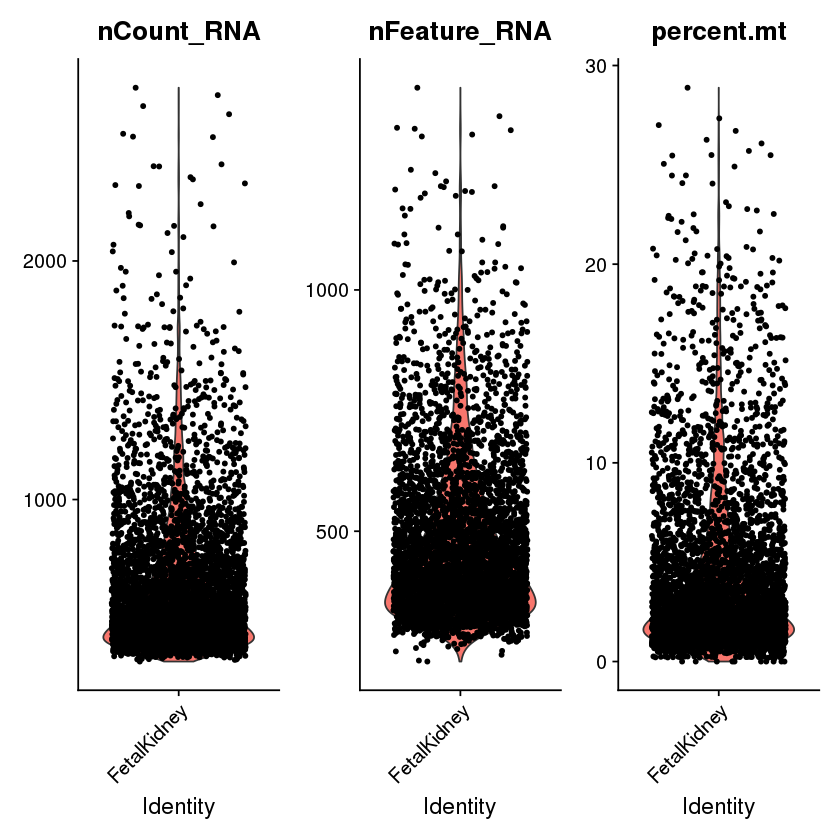

In [4]:
# Pre-processing
min.features = 20
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [5]:
percent.mt.thre = 25
nFeature_RNA_range = c(min.features, 1500)
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [6]:
warnings('off')
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)

In [7]:
# *--------------------Load reference table--------------------*
print("=========Loading Reference Table=========")
ref_table_raw <- read.csv("/data8t_0/hms/workspace/Rtoolkit_GeneSymbolUniform/GeneSymbolRef_SelectAll_upd0731.csv", header=TRUE, na.strings=TRUE, stringsAsFactors=FALSE)
# print(dim(ref_table_raw))
print("Finished")
# *--------------------Load total gene list--------------------*
print("=========Processing Gene List=========")
total_gene_list_raw = read.table("/data8t_0/hms/workspace/Rtoolkit_GeneSymbolUniform/total_gene_list_43878.txt", 
                                 header=TRUE, sep='\t', fill=TRUE, stringsAsFactors=FALSE)
total_gene_list = total_gene_list_raw[,1]
# Seurat changes all "_" to "-".
total_gene_list <- str_replace(total_gene_list, "_", "-")
print("The length of gene list is: ")
print(length(total_gene_list))
print("Finished")
print("=========Processing Reference Table=========")
# Separate dataframe to previous and alias symbol sub-dataframe
# Remove duplicates and empty values
ref_table_raw <- ref_table_raw[,c("Approved.symbol","Alias.symbol","Previous.symbol")]
ref_table <- ref_table_raw[ref_table_raw[,"Previous.symbol"]!="" | ref_table_raw[,"Alias.symbol"]!="",]
# Seurat changes all "_" to "-".
ref_table$Previous.symbol <- str_replace(ref_table$Previous.symbol, "_", "-")
ref_table$Alias.symbol <- str_replace(ref_table$Alias.symbol, "_", "-")
ref_table$Approved.symbol <- str_replace(ref_table$Approved.symbol, "_", "-")
# print(dim(ref_table))
ref_table_prev <- unique(ref_table[,c("Approved.symbol","Previous.symbol")])
ref_table_prev <- ref_table_prev[ref_table_prev[,"Previous.symbol"]!="",]
ref_table_alia <- unique(ref_table[,c("Approved.symbol","Alias.symbol")])
ref_table_alia <- ref_table_alia[ref_table_alia[,"Alias.symbol"]!="",]
# print(dim(ref_table_prev))
# print(dim(ref_table_alia))
print("Finished")

# *--------------------Load query data--------------------*
print("=========Loading Query Data=========")
query_data <- as.data.frame(as.matrix(dataobj@assays$RNA@data))
query_gene_list <- rownames(dataobj)
print("The shape of query data is: ")
print(dim(query_data))
print("Print out first 5 genes in query data, in case something wrong happens in data loading: ")
print(query_gene_list[1:5])
print("Finished")

# *--------------------Perform gene name uniform--------------------*
print("=========Performing Gene Symbol Uniform=========")
print("Performing gene symbol uniform, this step may take several minutes")
gene_appearance_list <- data.frame(gene_name=total_gene_list, appearance=rep(FALSE, length(total_gene_list)))
outlier_gene_list <- c()

result_data <- query_data
result_data$genenames <- rownames(result_data)
report <- data.frame(Original.Name=character(), Modified.Name=character(), Status=character(), stringsAsFactors=FALSE)

for (i in c(1:length(query_gene_list))){
  gene_name <- query_gene_list[i]
  # Modify gene symbols, both "Alias symbol" and "Previous symbol" are used. 
  if(sum(ref_table_prev["Previous.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_prev["Previous.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
    
  else if(sum(ref_table_alia["Alias.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_alia["Alias.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
  
  # Gene name not found
  else{
    report[i,] <- c(gene_name, gene_name, "No Change")
    if(gene_name %in% total_gene_list){
      gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
    }
    else{
      outlier_gene_list <- c(outlier_gene_list, gene_name)
    }
  }
}
print("Finished")

# *--------------------Construct uniform output--------------------*
print("=========Building Output Matrix=========")
result_data_grouped <- result_data %>% group_by(genenames) %>% summarise_at(vars(-group_cols()), mean)
result_data_sub <- as.data.frame(result_data_grouped)[which(!result_data_grouped$genenames %in% outlier_gene_list),]
result_data_out <- subset(result_data_sub, select = -genenames )
rownames(result_data_out) <- result_data_sub$genenames
print("Shape of processed query data: ")
print(dim(result_data_out))

add_df <- data.frame(matrix(nrow=sum(gene_appearance_list$appearance==FALSE),ncol=dim(result_data)[2]-1, 0))
rownames(add_df) <- gene_appearance_list$gene_name[!gene_appearance_list$appearance]
colnames(add_df) <- colnames(result_data_out)

result_data_out <- rbind(result_data_out, add_df)
print("Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged.")
print(dim(result_data_out))
print("Finished")

[1] "=========Loading Reference Table========="
[1] "Finished"
[1] "=========Processing Gene List========="
[1] "The length of gene list is: "
[1] 43878
[1] "Finished"
[1] "=========Processing Reference Table========="
[1] "Finished"
[1] "=========Loading Query Data========="
[1] "The shape of query data is: "
[1] 23273  4723
[1] "Print out first 5 genes in query data, in case something wrong happens in data loading: "
[1] "A1CF"    "A2M"     "A2M-AS1" "A2ML1"   "A4GALT" 
[1] "Finished"
[1] "=========Performing Gene Symbol Uniform========="
[1] "Performing gene symbol uniform, this step may take several minutes"
[1] "Finished"
[1] "=========Building Output Matrix========="
[1] "Shape of processed query data: "
[1] 18263  4723
[1] "Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged."
[1] 43878  4723
[1] "Finished"


In [8]:
dataobj <- CreateSeuratObject(result_data_out,meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Warning message in CreateSeuratObject(result_data_out, meta.data = data.metadata):
“Some cells in meta.data not present in provided counts matrix.”
Centering and scaling data matrix



PC_ 1 
Positive:  LGALS1, TM4SF1, TMSB4X, B2M, IGFBP5, A2M, CCL2, FN1, EMCN, PLVAP 
	   SLC2A3, CD34, PECAM1, FLT1, GMFG, SOCS3, ITM2A, APLNR, CAVIN2, KDR 
	   IFITM3, TIMP1, TIMP3, EDNRB, SPARC, RAMP2, LYVE1, IFITM2, ZFP36, PRCP 
Negative:  MT-CO1, MT-CO3, FTL, CD24, MT-CO2, CYB5A, FXYD2, MT-ATP6, PTGR1, AFP 
	   MT-ND4, DEFB1, SMIM24, RIDA, MPC2, MT-CYB, WFDC2, SLC3A1, GPX3, CUBN 
	   CLDN4, KCNJ15, NDUFA4, APOM, LRP2, CLDN10, MT-TW, MT-ND1, GLYATL1, KRT8 
PC_ 2 
Positive:  AFP, GPX3, CUBN, GATM, LRP2, SLC3A1, APOM, SMIM24, GLYATL1, FABP1 
	   AQP1, MT1G, BHMT, ENPEP, HSPA5, KCNJ15, TNFSF10, RIDA, ITM2B, ALDOB 
	   MT1H, GPC3, VCAN, CCN1, CA2, SULT1E1, FTL, FTH1, MT1X, HSP90B1 
Negative:  RPS18, RPS14, RPS27, RPL31, RPS19, RPL7, RPS6, RPS3, RPL21, RPL34 
	   RPLP1, RPL27A, RPS27A, RPL32, RPL23A, RPL35A, RPL36, RPS3A, RPS29, TMSB10 
	   RPL13A, RPL3, RPS13, PTMA, RPS23, RPL11, RPS15A, RPL37A, EEF1A1, RPL30 
PC_ 3 
Positive:  FTL, B2M, MT-RNR2, MT-CO1, MT-ATP6, MT-RNR1, MT-ND4, MT-CO2,

png 
  2

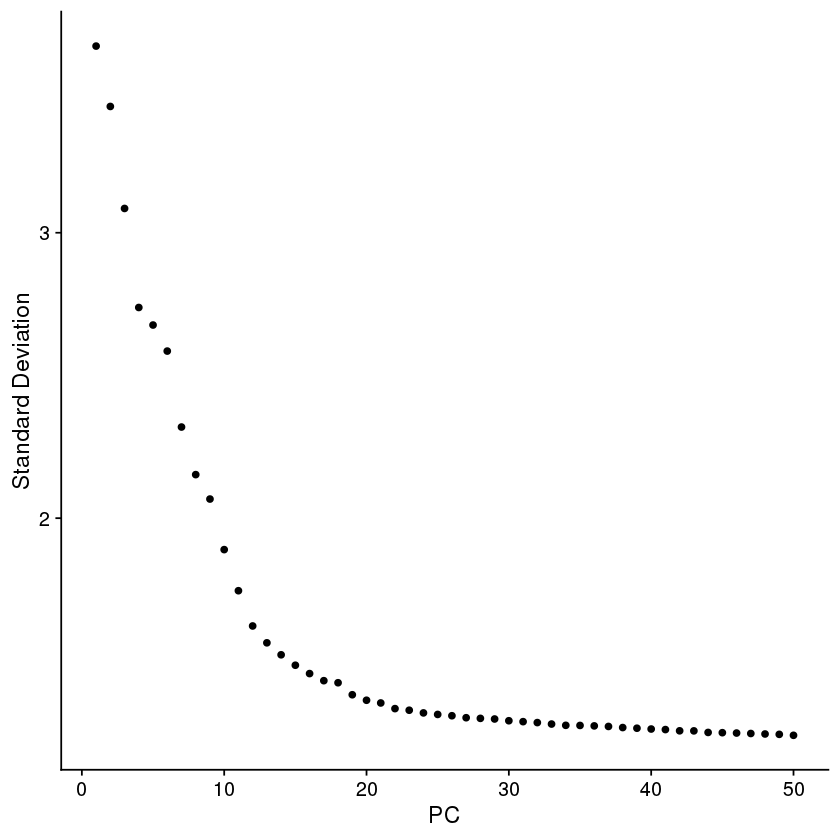

In [9]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj),npcs=50)
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj,ndim=50) 
dev.off()
ElbowPlot(dataobj,ndim=50) 

In [10]:
pcDim = 30 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph

Computing SNN



In [17]:
dataobj <- FindClusters(dataobj, resolution = 1.5, n.start = 5)
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4723
Number of edges: 209936

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.7397
Number of communities: 16
Elapsed time: 0 seconds


ARI 
0.5056434

In [18]:
dataobj <- RunUMAP(dataobj,dims=1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:52:15 UMAP embedding parameters a = 0.9922 b = 1.112

16:52:15 Read 4723 rows and found 30 numeric columns

16:52:15 Using Annoy for neighbor search, n_neighbors = 30

16:52:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

16:52:16 Writing NN index file to temp file /tmp/RtmpOGfCi3/filed71e7ece093e

16:52:17 Searching Annoy index using 1 thread, search_k = 3000

16:52:18 Annoy recall = 100%

16:52:19 Commencing smooth kNN distance calibration using 1 thread

16:52:20 Initializing fr

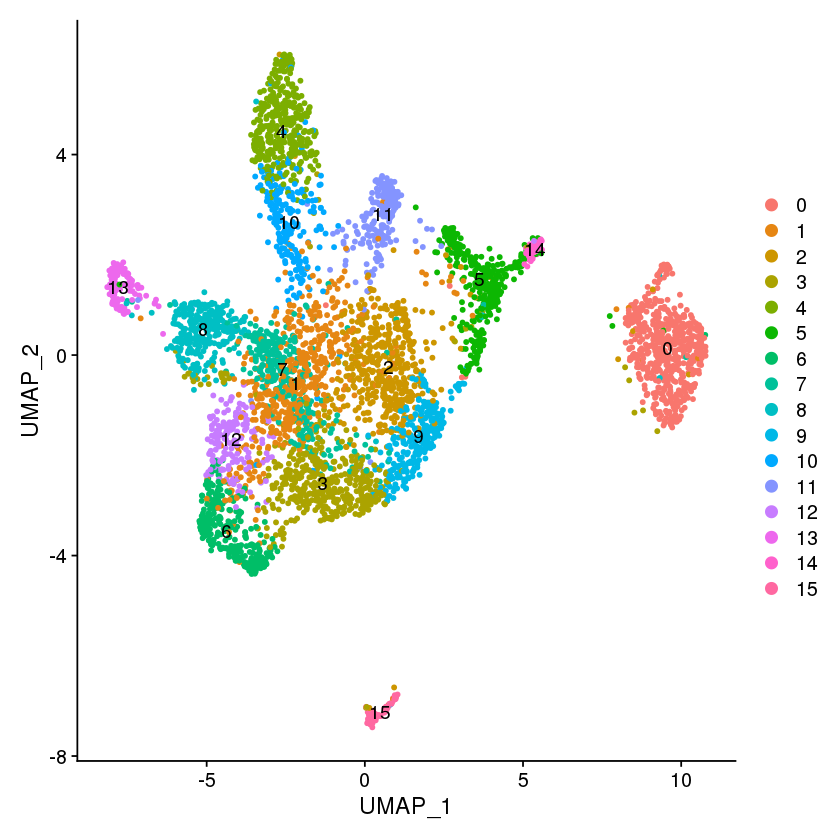

In [19]:
p_umap=DimPlot(dataobj,label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)
p_umap

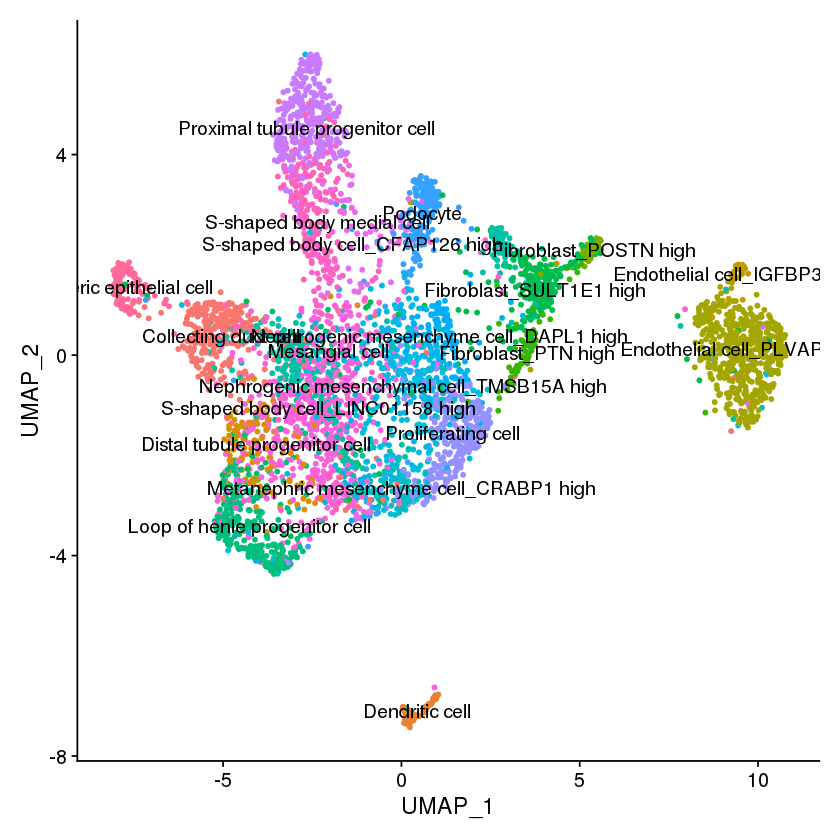

In [20]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = T, group.by = "cell_cluster", pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)
p_umap2

In [41]:
new.cluster.ids <- c(
                     "Kidney-Epithelial tissue-Endothelial cell-PLVAP",
                     "Kidney-Connective tissue-Mesenchymal cell-PANTR1", 
                     "Kidney-Connective tissue-Mesenchymal cell-TMSB15A", 
                     "Kidney-Unknown", 
                     "Kidney-Epithelial tissue-Proximal convoluted tubule progenitor-AFP", 
                     "Kidney-Connective tissue-Fibroblast-COL1A2",
                     "Kidney-Epithelial tissue-Loop of Henle progenitor-SLC12A1", 
                     "Kidney-Epithelial tissue-Collecting duct-CALB1", 
                     "Kidney-Epithelial tissue-Collecting duct-CALB1", 
                     "Kidney-Epithelial tissue-Proliferating cell-CCNB1", 
                     "Kidney-S-shaped body cell-SMIM24",
                     "Kidney-Epithelial tissue-Podocyte-MAFB", 
                     "Kidney-Epithelial tissue-Distal convoluted tubule-DEFB1", 
                     "Kidney-Epithelial tissue-Ureteric epithelial cell-S100P", 
                     "Kidney-Connective tissue-Fibroblast-COL1A2",
                     "Kidney-Connective tissue-Dendritic cell-IL1B"
                    )

In [42]:
subset(dataobj.markers,cluster=='15')
# subset(dataobj.markers,gene=='C1QA')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
SRGN,0.000000e+00,3.739139,0.820,0.013,0.000000e+00,15,SRGN
FCER1G,0.000000e+00,2.900107,0.639,0.008,0.000000e+00,15,FCER1G
GPR183,0.000000e+00,2.866755,0.459,0.003,0.000000e+00,15,GPR183
CCL3L3,3.369499e-305,3.730617,0.525,0.005,1.478469e-300,15,CCL3L3
RGS1,5.670034e-301,2.882271,0.393,0.002,2.487897e-296,15,RGS1
CCL4,1.203188e-286,3.932114,0.508,0.005,5.279346e-282,15,CCL4
HLA-DRA,3.213277e-263,3.475434,0.607,0.011,1.409922e-258,15,HLA-DRA
CCL3,1.712745e-258,3.487952,0.443,0.004,7.515184e-254,15,CCL3
LGALS13,1.450799e-245,2.478501,0.344,0.002,6.365816e-241,15,LGALS13


In [43]:
names(x = new.cluster.ids) <- levels(x = dataobj)
annodataobj <- RenameIdents(object = dataobj, new.cluster.ids)

In [44]:
annodataobj <- RunUMAP(annodataobj,dims=1:pcDim)

17:19:32 UMAP embedding parameters a = 0.9922 b = 1.112

17:19:32 Read 4723 rows and found 30 numeric columns

17:19:32 Using Annoy for neighbor search, n_neighbors = 30

17:19:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

17:19:33 Writing NN index file to temp file /tmp/RtmpOGfCi3/filed71e7276a9a0

17:19:33 Searching Annoy index using 1 thread, search_k = 3000

17:19:35 Annoy recall = 100%

17:19:35 Commencing smooth kNN distance calibration using 1 thread

17:19:36 Initializing from normalized Laplacian + noise

17:19:36 Commencing optimization for 500 epochs, with 204526 positive edges

17:19:53 Optimization finished



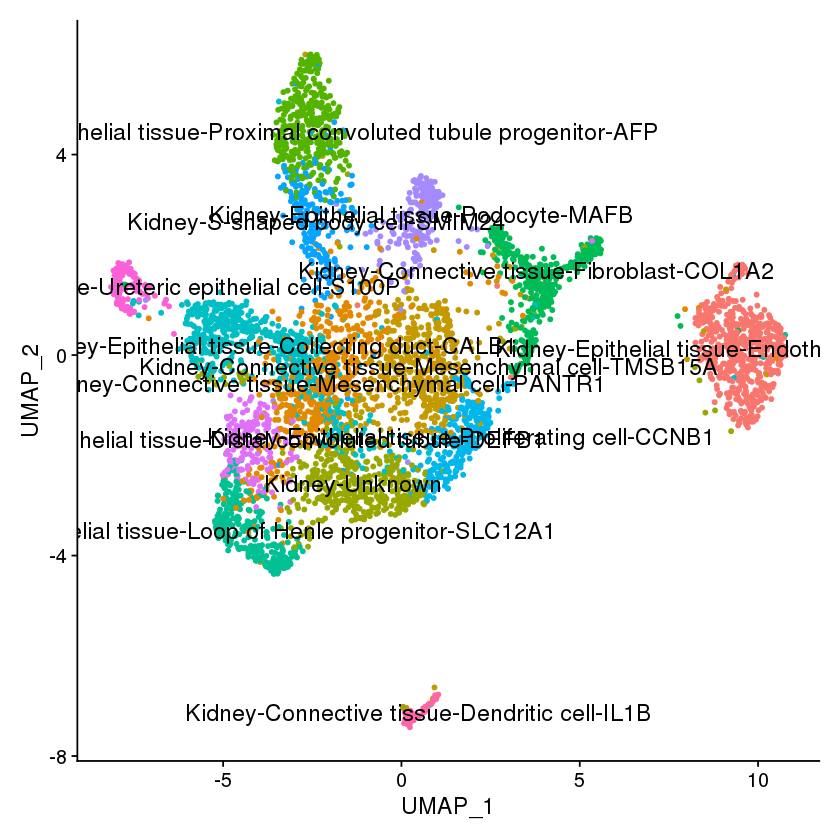

In [45]:
p_umap4 <- UMAPPlot(annodataobj,label = T, pt.size=1,label.size=5)+NoLegend()
# LabelClusters(plot = p_umap4, id = 'ident', color = 'white')
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap4, width = 25, height = 15)
p_umap4

In [21]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



In [46]:

write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(annodataobj@active.ident),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [47]:
print(levels(dataobj$sample_status))
dataobj

[1] "normal"


An object of class Seurat 
43878 features across 4723 samples within 1 assay 
Active assay: RNA (43878 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [50]:
# ncol(result_data_out
levels(dataobj$donor_age)    

[1] "13W"

In [51]:
levels(dataobj$donor_age)  <- c('GW13')

In [52]:
dataobj.dbupload_v1 <- CreateSeuratObject(result_data_out)
# dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v1[['orig.ident']] <- NULL
dataobj.dbupload_v1[['nCount_RNA']] <- NULL
dataobj.dbupload_v1[['nFeature_RNA']] <- NULL
dataobj.dbupload_v1$user_id <- 1
dataobj.dbupload_v1$study_id<-"10.1038/s41586-020-2157-4"
dataobj.dbupload_v1$cell_id <- colnames(dataobj.dbupload_v1@assays$RNA@data)
dataobj.dbupload_v1$organ<-"Kidney"
dataobj.dbupload_v1$region<-"NA"
dataobj.dbupload_v1$subgion<-"NA"
dataobj.dbupload_v1$seq_tech<-"Microwell-seq"
dataobj.dbupload_v1$sample_status<-"Healthy"
dataobj.dbupload_v1$donor_id<-dataobj$donor_ID
dataobj.dbupload_v1$donor_gender<-dataobj$donor_gender
dataobj.dbupload_v1$donor_age<- dataobj$donor_age
dataobj.dbupload_v1$original_name<-dataobj$cell_cluster
dataobj.dbupload_v1$cl_name<-"NA"
dataobj.dbupload_v1$hcad_name<-dataobj$hcad.label

In [53]:
dataobj.dbupload_v1$original_name<-as.character(dataobj.dbupload_v1$original_name)
dataobj.dbupload_v1$donor_id<-as.character(dataobj.dbupload_v1$donor_id)
dataobj.dbupload_v1$donor_gender<-as.character(dataobj.dbupload_v1$donor_gender)

In [54]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [55]:
colnames(dataobj.dbupload_v1@meta.data)

[1] "user_id"       "study_id"      "cell_id"       "organ"        
 [5] "region"        "subgion"       "seq_tech"      "sample_status"
 [9] "donor_id"      "donor_gender"  "donor_age"     "original_name"
[13] "cl_name"       "hcad_name"

In [56]:
dataobj.dbupload_v1

An object of class Seurat 
43878 features across 4723 samples within 1 assay 
Active assay: RNA (43878 features, 0 variable features)

In [57]:
head(dataobj.dbupload_v1[[]],3)

,user_id,study_id,cell_id,organ,region,subgion,seq_tech,sample_status,donor_id,donor_gender,donor_age,original_name,cl_name,hcad_name
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>
FetalKidney_4.AAAACGACGTTGTCTACC,1,10.1038/s41586-020-2157-4,FetalKidney_4.AAAACGACGTTGTCTACC,Kidney,NA,NA,Microwell-seq,Healthy,FetalKidney4_13W,Female,GW13,Endothelial cell_PLVAP high,NA,Kidney-Epithelial tissue-Endothelial cell-PLVAP
FetalKidney_4.AAAACGACTTATAAAACG,1,10.1038/s41586-020-2157-4,FetalKidney_4.AAAACGACTTATAAAACG,Kidney,NA,NA,Microwell-seq,Healthy,FetalKidney4_13W,Female,GW13,Endothelial cell_PLVAP high,NA,Kidney-Epithelial tissue-Loop of Henle progenitor-SLC12A1
FetalKidney_4.AAAACGATCAACAGCGAG,1,10.1038/s41586-020-2157-4,FetalKidney_4.AAAACGATCAACAGCGAG,Kidney,NA,NA,Microwell-seq,Healthy,FetalKidney4_13W,Female,GW13,Nephrogenic mesenchymal cell_TMSB15A high,NA,Kidney-Connective tissue-Mesenchymal cell-TMSB15A


In [3]:
dataobj.dbupload_v1 <- readRDS( file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))
unique(dataobj.dbupload_v1[['hcad_name']])

,hcad_name
,<chr>
FetalKidney_4.AAAACGACGTTGTCTACC,Kidney-Epithelial tissue-Endothelial cell-PLVAP
FetalKidney_4.AAAACGACTTATAAAACG,Kidney-Epithelial tissue-Loop of henle progenitor-SLC12A1
FetalKidney_4.AAAACGATCAACAGCGAG,Kidney-Connective tissue-Mesenchymal cell-TMSB15A
FetalKidney_4.AAAACGCAAAGTCGTGGC,Kidney-Epithelial tissue-Proximal convoluted tubule progenitor-AFP
FetalKidney_4.AAAACGCCTTTCGCTGTG,Kidney-Epithelial tissue-Podocyte-MAFB
FetalKidney_4.AAAACGGAATTACTGTGT,Kidney-Connective tissue-Mesenchymal cell-PANTR1
FetalKidney_4.AAAACGGTAATGATCAAC,Kidney-Epithelial tissue-Proliferating cell-CCNB1
FetalKidney_4.AAAACGGTGGTATACTTC,Kidney-Unknown
FetalKidney_4.AAAGTTACAATATGCAAT,Kidney-Epithelial tissue-Collecting duct-CALB1


In [6]:
dataobj.dbupload_v1$hcad_name<- sub("Kidney-Unknown","Unknown",dataobj.dbupload_v1$hcad_name)
unique(dataobj.dbupload_v1[['hcad_name']])

,hcad_name
,<chr>
FetalKidney_4.AAAACGACGTTGTCTACC,Kidney-Epithelial tissue-Endothelial cell-PLVAP
FetalKidney_4.AAAACGACTTATAAAACG,Kidney-Epithelial tissue-Loop of henle progenitor-SLC12A1
FetalKidney_4.AAAACGATCAACAGCGAG,Kidney-Connective tissue-Mesenchymal cell-TMSB15A
FetalKidney_4.AAAACGCAAAGTCGTGGC,Kidney-Epithelial tissue-Proximal convoluted tubule progenitor-AFP
FetalKidney_4.AAAACGCCTTTCGCTGTG,Kidney-Epithelial tissue-Podocyte-MAFB
FetalKidney_4.AAAACGGAATTACTGTGT,Kidney-Connective tissue-Mesenchymal cell-PANTR1
FetalKidney_4.AAAACGGTAATGATCAAC,Kidney-Epithelial tissue-Proliferating cell-CCNB1
FetalKidney_4.AAAACGGTGGTATACTTC,Unknown
FetalKidney_4.AAAGTTACAATATGCAAT,Kidney-Epithelial tissue-Collecting duct-CALB1


In [7]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))